In [2]:
import ee
import pandas as pd

# Authenticate and initialize Earth Engine
ee.Initialize(project='ac215-final-project')

# Load your CSV
df = pd.read_csv('data/csv_data/dataset_index.csv')

# Extract coordinate tuples
coords = list(zip(df['longitude'], df['latitude']))

In [ ]:
# Create FeatureCollection of all points
features = [ee.Feature(ee.Geometry.Point([lon, lat]), {'lon': lon, 'lat': lat}) for lon, lat in coords]
points_fc = ee.FeatureCollection(features)

# Load datasets once
precip = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')\
            .filterDate('2016-01-01', '2016-12-31').mean()

elevation = ee.Image('USGS/SRTMGL1_003')

ndvi = ee.ImageCollection('MODIS/061/MOD13A2')\
         .filterDate('2016-01-01', '2016-12-31')\
         .select('NDVI').mean().multiply(0.0001)

night_lights = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG')\
                 .filterDate('2016-01-01', '2016-12-31')\
                 .select('avg_rad').mean()

population = ee.ImageCollection('WorldPop/GP/100m/pop')\
                .filterDate('2016-01-01', '2016-12-31')\
                .mean().rename('population')

soil_moisture = ee.ImageCollection('NASA/SMAP/SPL3SMP_E/006')\
                    .filterDate('2016-01-01', '2016-12-31')\
                    .select('soil_moisture_am').mean()

slope = ee.Terrain.products(elevation).select('slope')

temperature = ee.ImageCollection('MODIS/061/MOD11A2')\
                  .filterDate('2016-01-01', '2016-12-31')\
                  .select('LST_Day_1km')\
                  .mean().multiply(0.02).subtract(273.15)  # Kelvin -> Celsius

# Load ERA5 air temp and dewpoint temp
era5 = ee.ImageCollection('ECMWF/ERA5/DAILY')\
           .filterDate('2016-01-01', '2016-12-31')\
           .mean()

t2m = era5.select('mean_2m_air_temperature').subtract(273.15)  # Kelvin -> Celsius
td2m = era5.select('dewpoint_2m_temperature').subtract(273.15)  # Kelvin -> Celsius

# Calculate relative humidity
def saturation_vapor_pressure(temp_c):
    return (17.625 * temp_c) / (243.04 + temp_c)

rh = td2m.expression(
    '100 * (exp((17.625 * TD) / (243.04 + TD)) / exp((17.625 * T) / (243.04 + T)))',
    {
        'TD': td2m,
        'T': t2m
    }
).rename('relative_humidity_pct')

# Stack everything into a single multiband image
stacked_image = precip.rename('precip_mm_yr')\
               .addBands(elevation.rename('elevation_m'))\
               .addBands(ndvi.rename('ndvi'))\
               .addBands(night_lights.rename('night_lights'))\
               .addBands(population.rename('pop_density'))\
               .addBands(soil_moisture.rename('soil_moisture'))\
               .addBands(slope.rename('slope_deg'))\
               .addBands(rh.rename('humidity_pct'))\
               .addBands(temperature.rename('temperature_c'))

# Reduce all points at once
reduced = stacked_image.reduceRegions(
    collection=points_fc,
    reducer=ee.Reducer.first(),
    scale=500
)

task = ee.batch.Export.table.toDrive(
    collection=reduced,
    description='Export_Env_Features',
    folder='EarthEngineExports',
    fileNamePrefix='eurosat_gee_features',
    fileFormat='CSV'
)
task.start()
print("Export task started!")

Make new CSV file

In [46]:
df_index = pd.read_csv('data/csv_data/dataset_index.csv')
df_ee = pd.read_csv('data/csv_data/eurosat_gee_features.csv')

In [40]:
df_index.shape, df_ee.shape

((27000, 14), (27000, 13))

In [8]:
df_ee.describe()

,system:index,elevation_m,humidity_pct,lat,lon,ndvi,night_lights,pop_density,precip_mm_yr,slope_deg,soil_moisture,temperature_c
count,27000.00000,26474.000000,27000.000000,27000.000000,27000.000000,26768.000000,27000.000000,24313.000000,16388.000000,26474.000000,25086.000000,26342.000000
mean,13499.50000,242.616189,74.364687,48.183512,8.967374,0.486738,8.070471,5.428215,1.930389,2.397673,0.243990,16.946892
std,7794.37297,341.311094,7.430612,5.912396,9.785837,0.174982,34.321855,14.369498,0.651144,4.092919,0.074265,5.454976
min,0.00000,-12.000000,47.172344,27.967059,-20.993893,-0.178250,0.029471,0.000000,0.528252,0.000000,0.087385,0.516667
25%,6749.75000,53.000000,71.655314,43.845534,1.524883,0.395887,0.325050,0.057781,1.582912,0.000000,0.204781,13.440386
50%,13499.50000,136.000000,76.488874,48.804167,8.086291,0.509352,0.737637,0.270617,1.840713,1.000000,0.229205,16.351819
75%,20249.25000,308.000000,79.426320,52.256146,16.252932,0.606862,5.816232,3.737983,2.177608,3.000000,0.263230,19.980723
max,26999.00000,2997.000000,86.817022,65.237817,33.528975,0.848209,2823.875977,249.366226,5.188347,42.000000,0.688594,37.296364


In [47]:
df_ee.soil_moisture.isna().sum()

1914

In [9]:
df_ee.head()

,system:index,elevation_m,humidity_pct,lat,lon,ndvi,night_lights,pop_density,precip_mm_yr,slope_deg,soil_moisture,temperature_c,.geo
0,0,77.0,77.111612,54.856372,23.641102,0.659196,0.529031,0.041575,NaN,1.0,0.251710,12.481892,"{""type"":""Point"",""coordinates"":[23.641102389288..."
1,1,441.0,71.237312,48.244798,17.130751,0.639922,0.657606,0.065251,2.397310,3.0,0.217507,13.600500,"{""type"":""Point"",""coordinates"":[17.130751455855..."
2,2,342.0,70.835289,47.896999,16.533918,0.664957,0.291409,0.113547,2.332740,3.0,0.220701,16.250513,"{""type"":""Point"",""coordinates"":[16.533917500002..."
3,3,780.0,74.132946,48.984167,21.372763,0.582652,0.293375,0.084624,2.071605,12.0,0.220068,11.287895,"{""type"":""Point"",""coordinates"":[21.372763180138..."
4,4,453.0,71.215708,48.249989,17.165984,0.666243,0.697825,0.161230,2.742228,10.0,0.217507,13.787949,"{""type"":""Point"",""coordinates"":[17.165984206832..."


In [41]:
country_ids = df_index['country_id'].fillna(0)
unique_ids = sorted(country_ids.unique())
id_mapping = {id_val: i for i, id_val in enumerate(unique_ids) if id_val != -1}
df_index['country_id'] = country_ids.map(id_mapping).astype(int)

In [48]:
# Select columns to include in final dataset
df_index_selected = df_index[['image_path', 'label', 'country_id', 'latitude', 'longitude']]
df_ee_selected = df_ee[['elevation_m', 'humidity_pct', 'ndvi', 'night_lights', 'pop_density', 'slope_deg', 'soil_moisture', 'temperature_c']]

# Concatenate side-by-side (axis=1 means columns)
df_final = pd.concat([df_index_selected, df_ee_selected], axis=1)

df_final.head()

,image_path,label,country_id,latitude,longitude,elevation_m,humidity_pct,ndvi,night_lights,pop_density,slope_deg,soil_moisture,temperature_c
0,EuroSAT_MS/Forest/Forest_2230.jpg,Forest,17,54.856372,23.641102,77.0,77.111612,0.659196,0.529031,0.041575,1.0,0.251710,12.481892
1,EuroSAT_MS/Forest/Forest_1739.jpg,Forest,25,48.244798,17.130751,441.0,71.237312,0.639922,0.657606,0.065251,3.0,0.217507,13.600500
2,EuroSAT_MS/Forest/Forest_343.jpg,Forest,0,47.896999,16.533918,342.0,70.835289,0.664957,0.291409,0.113547,3.0,0.220701,16.250513
3,EuroSAT_MS/Forest/Forest_425.jpg,Forest,25,48.984167,21.372763,780.0,74.132946,0.582652,0.293375,0.084624,12.0,0.220068,11.287895
4,EuroSAT_MS/Forest/Forest_2556.jpg,Forest,25,48.249989,17.165984,453.0,71.215708,0.666243,0.697825,0.161230,10.0,0.217507,13.787949


<Axes: xlabel='label'>

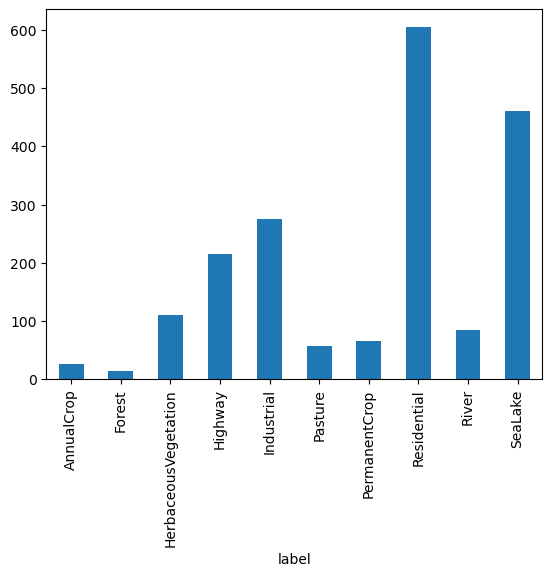

In [53]:
df_final.groupby('label')['soil_moisture'].apply(lambda x: x.isna().sum()).plot(kind='bar')

In [56]:
df_final.isna().sum()

image_path          0
label               0
country_id          0
latitude            0
longitude           0
elevation_m       526
humidity_pct        0
ndvi              232
night_lights        0
pop_density      2687
slope_deg         526
soil_moisture    1914
temperature_c     658
dtype: int64

In [44]:
nan_cols = df_final.columns[df_final.isna().any()]
df_final[nan_cols] = df_final[nan_cols].fillna(df_final[nan_cols].mean())

In [34]:
df_final.head()

,image_path,label,country_id,latitude,longitude,elevation_m,humidity_pct,ndvi,night_lights,pop_density,slope_deg,soil_moisture,temperature_c
0,EuroSAT_MS/Forest/Forest_2230.jpg,Forest,106.0,54.856372,23.641102,77.0,77.111612,0.659196,0.529031,0.041575,1.0,0.251710,12.481892
1,EuroSAT_MS/Forest/Forest_1739.jpg,Forest,165.0,48.244798,17.130751,441.0,71.237312,0.639922,0.657606,0.065251,3.0,0.217507,13.600500
2,EuroSAT_MS/Forest/Forest_343.jpg,Forest,10.0,47.896999,16.533918,342.0,70.835289,0.664957,0.291409,0.113547,3.0,0.220701,16.250513
3,EuroSAT_MS/Forest/Forest_425.jpg,Forest,165.0,48.984167,21.372763,780.0,74.132946,0.582652,0.293375,0.084624,12.0,0.220068,11.287895
4,EuroSAT_MS/Forest/Forest_2556.jpg,Forest,165.0,48.249989,17.165984,453.0,71.215708,0.666243,0.697825,0.161230,10.0,0.217507,13.787949


In [45]:
df_final.to_csv("data/csv_data/dataset_index.csv")